<a href="https://colab.research.google.com/github/yunaficus/DRL/blob/main/HW4_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# hw4-1

🧾 小報告：以 DQN 強化學習實作簡易環境學習與經驗回放機制
一、前言
本報告探討了以 DQN（Deep Q-Network） 實作強化學習於簡單環境（Gridworld）中的學習歷程與模型訓練架構，並著重於兩個核心重點：

基本 DQN 架構於簡易環境中的應用

引入經驗回放（Experience Replay Buffer）提升學習穩定性與效率

透過 Python、PyTorch 與自定義 Gridworld 環境的整合，這份程式碼展現了由基本強化學習到進階機制的實作過程與效果分析。

二、Basic DQN Implementation for an Easy Environment
2.1 環境介紹：Gridworld
Gridworld 是一個簡單的 4×4 格狀迷宮，包含「玩家起點」、「目標終點」與「陷阱」，代理人（Agent）需學會選擇正確路徑以最大化 reward。環境可設為：

static：固定配置（起點與終點不變）

random：每場隨機產生新迷宮

player：由玩家設定起點終點位置

2.2 DQN 架構設計
DQN 是將傳統 Q-learning 中的 Q 表轉換為神經網路，透過函數近似器處理大型或連續狀態空間。

model = torch.nn.Sequential(
    torch.nn.Linear(64, 150),
    torch.nn.ReLU(),
    torch.nn.Linear(150, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 4)
)

輸入層：64 維（將 Gridworld 4×4×4 壓平）

輸出層：4 維，對應四個動作（上、下、左、右）

使用 ReLU 激活函數

損失函數：MSE（均方誤差）

優化器：Adam

2.3 ε-greedy 策略與訓練流程
模型訓練透過 ε-greedy 策略平衡探索與利用：

隨機選動作（探索）或選 Q 值最大者（利用）

每個 epoch 遊戲結束後更新網路，計算 loss 並透過反向傳播優化

學習過程中，ε 值逐步下降，減少探索傾向，最終保留最低 0.1。

三、Experience Replay Buffer
3.1 為什麼需要 Replay Buffer？
傳統 Q-learning 或 DQN 會依照時間順序處理資料，導致資料高度相關，使訓練不穩定。Replay Buffer 的引入可達到以下優勢：

打破資料之間的相關性（破壞時間序列）

重複使用資料（提高樣本效率）

小批量訓練（mini-batch training）加速收斂

3.2 機制與實作

from collections import deque

replay = deque(maxlen=1000)  # 限制大小
minibatch = random.sample(replay, batch_size)  # 隨機抽樣
每一步經驗紀錄為：


(state, action, reward, next_state, done)
當經驗量足夠後，從記憶體中隨機抽取 batch_size 筆資料進行訓練，並依據 Q-learning 更新目標值：

Y = reward_batch + γ * ((1 - done_batch) * max(Q(s′)))
這可避免同樣情況持續出現導致模型偏誤學習。

四、進階設計與優化
4.1 目標網路（Target Network）
進一步引入 Target Network（model2），用於穩定目標 Q 值計算，並每隔固定步數同步參數。


if j % sync_freq == 0:
    model2.load_state_dict(model.state_dict())
4.2 避免撞牆懲罰
透過 validateMove() 判斷是否撞牆，並給予額外懲罰（如 reward = -5），強化代理人避免無效動作。

五、訓練結果與成效
5.1 損失值趨勢
透過繪圖顯示訓練過程中 loss 的下降趨勢，可評估模型收斂狀況。

5.2 測試勝率
在測試階段模擬 1000 次遊戲，統計代理人勝率（到達終點）作為最終模型表現指標。

六、結論與心得
這份程式碼展示了從基本 DQN 到引入經驗回放與目標網路的完整強化學習訓練流程。重點包括：

神經網路模型作為 Q 函數近似器。

經驗回放與隨機抽樣提升學習效率與泛化能力。

避免撞牆、勝率統計等優化手段提升模型實用性。

透過這樣的實驗平台，不僅能夠加深對 DQN 原理的理解，也為日後在複雜環境中實作如 Atari、OpenAI Gym 等強化學習任務打下良好基礎。



# hw4-2
part1 Double DQN implement  
part2 Dueling DQN implement  
paet3 Basic DQN implement  
part4 comparison

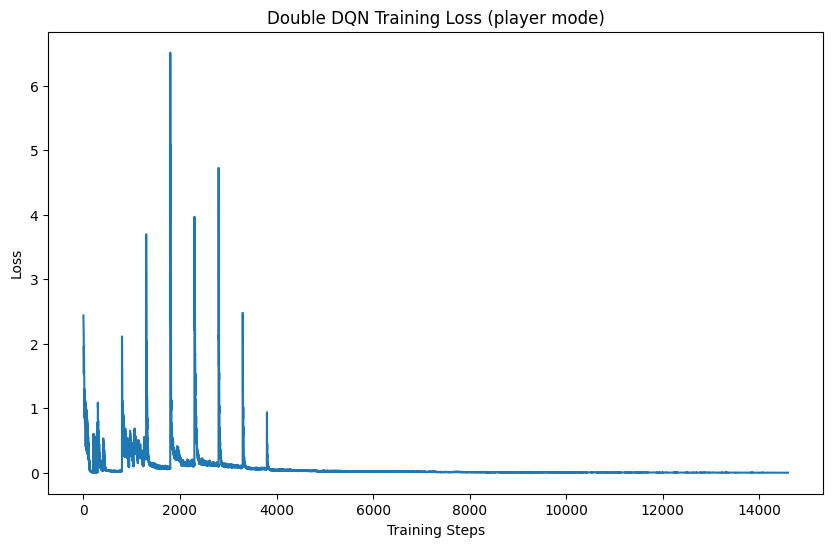

In [7]:
import numpy as np
import torch
import random
import copy
from collections import deque
from Gridworld import Gridworld
from IPython.display import clear_output
from matplotlib import pyplot as plt

# 動作對應表
action_set = {0: 'u', 1: 'd', 2: 'l', 3: 'r'}

# 模型架構與初始化
L1, L2, L3, L4 = 64, 150, 100, 4  # 網路層維度
model = torch.nn.Sequential(
    torch.nn.Linear(L1, L2),
    torch.nn.ReLU(),
    torch.nn.Linear(L2, L3),
    torch.nn.ReLU(),
    torch.nn.Linear(L3, L4)
)

model2 = copy.deepcopy(model)  # 建立目標網路
model2.load_state_dict(model.state_dict())

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
gamma = 0.9
epsilon = 1.0

# 訓練參數
epochs = 1000
batch_size = 200
mem_size = 1000
sync_freq = 500
replay = deque(maxlen=mem_size)
DoubleDQN_losses = []
j = 0  # 記錄步數

for i in range(epochs):
    game = Gridworld(size=4, mode='player')
    state_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64)/10.0
    state1 = torch.from_numpy(state_).float()
    status = 1
    while status == 1:
        j += 1
        qval = model(state1)
        qval_ = qval.data.numpy()

        if random.random() < epsilon:
            action_ = np.random.randint(0, 4)
        else:
            action_ = np.argmax(qval_)

        action = action_set[action_]
        game.makeMove(action)

        state2_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64)/10.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        done = reward != -1

        # 儲存到 Replay Buffer
        replay.append((state1, action_, reward, state2, done))
        state1 = state2

        if len(replay) > batch_size:
            minibatch = random.sample(replay, batch_size)
            state1_batch = torch.cat([s1 for (s1, a, r, s2, d) in minibatch])
            action_batch = torch.Tensor([a for (s1, a, r, s2, d) in minibatch])
            reward_batch = torch.Tensor([r for (s1, a, r, s2, d) in minibatch])
            state2_batch = torch.cat([s2 for (s1, a, r, s2, d) in minibatch])
            done_batch = torch.Tensor([d for (s1, a, r, s2, d) in minibatch])

            # --- Double DQN 核心部分 ---
            Q1 = model(state1_batch)
            with torch.no_grad():
                next_actions = torch.argmax(model(state2_batch), dim=1)  # 主網路選動作
                Q2 = model2(state2_batch)
                next_Q = Q2.gather(1, next_actions.unsqueeze(1)).squeeze()
            Y = reward_batch + gamma * ((1 - done_batch) * next_Q)
            X = Q1.gather(1, action_batch.long().unsqueeze(1)).squeeze()
            loss = loss_fn(X, Y.detach())
            # ---------------------------

            if i % 100 == 0:
                print(f"Epoch {i}, Loss: {loss.item()}")
                clear_output(wait=True)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            DoubleDQN_losses.append(loss.item())

            # 每 sync_freq 步更新目標網路
            if j % sync_freq == 0:
                model2.load_state_dict(model.state_dict())

        if abs(reward) == 10:
            status = 0

    if epsilon > 0.1:
        epsilon -= 1/epochs

# 繪製 Loss 曲線
plt.figure(figsize=(10, 6))
plt.plot(DoubleDQN_losses)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Double DQN Training Loss (player mode)")
plt.show()


In [4]:
import torch
import torch.nn as nn

class DuelingDQN(nn.Module):
    def __init__(self, input_dim, hidden1, hidden2, output_dim):
        super(DuelingDQN, self).__init__()

        # 通用特徵提取層
        self.feature = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU()
        )

        # 優勢層
        self.advantage = nn.Sequential(
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, output_dim)
        )

        # 價值層
        self.value = nn.Sequential(
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, 1)  # 只需一個數值表示狀態價值
        )

    def forward(self, x):
        # 提取特徵
        x = self.feature(x)

        # 計算優勢
        A = self.advantage(x)

        # 計算價值
        V = self.value(x)

        # 組合 Q 值
        Q = V + A - A.mean(dim=1, keepdim=True)
        return Q


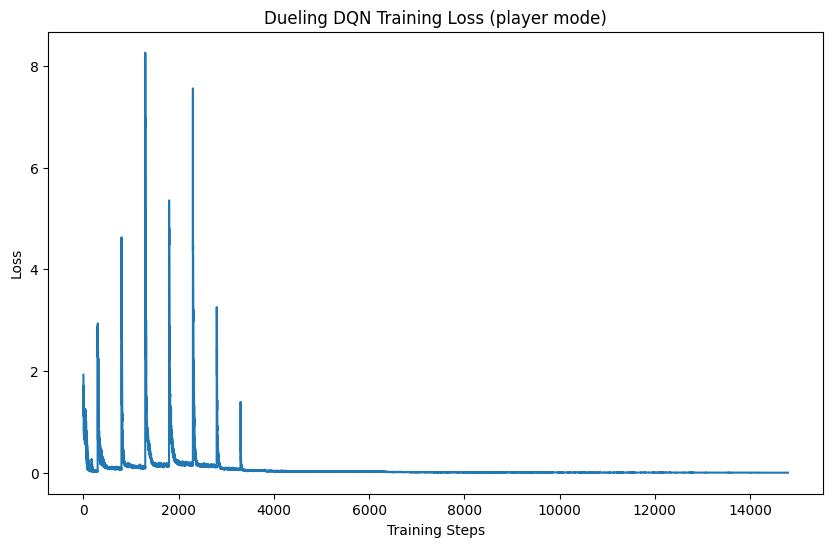

In [6]:
import numpy as np
import torch
import random
import copy
from collections import deque
from Gridworld import Gridworld
from IPython.display import clear_output
from matplotlib import pyplot as plt

# 動作對應表
action_set = {0: 'u', 1: 'd', 2: 'l', 3: 'r'}

# 模型架構與初始化
L1, L2, L3, L4 = 64, 150, 100, 4  # 網路層維度
model = DuelingDQN(L1, L2, L3, L4)
model2 = copy.deepcopy(model)  # 建立目標網路
model2.load_state_dict(model.state_dict())

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
gamma = 0.9
epsilon = 1.0

# 訓練參數
epochs = 1000
batch_size = 200
mem_size = 1000
sync_freq = 500
replay = deque(maxlen=mem_size)
DuelingDQN_losses = []
j = 0  # 記錄步數

for i in range(epochs):
    game = Gridworld(size=4, mode='player')
    state_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64)/10.0
    state1 = torch.from_numpy(state_).float()
    status = 1
    while status == 1:
        j += 1
        qval = model(state1)
        qval_ = qval.data.numpy()

        if random.random() < epsilon:
            action_ = np.random.randint(0, 4)
        else:
            action_ = np.argmax(qval_)

        action = action_set[action_]
        game.makeMove(action)

        state2_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64)/10.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        done = reward != -1

        # 儲存到 Replay Buffer
        replay.append((state1, action_, reward, state2, done))
        state1 = state2

        if len(replay) > batch_size:
            minibatch = random.sample(replay, batch_size)
            state1_batch = torch.cat([s1 for (s1, a, r, s2, d) in minibatch])
            action_batch = torch.Tensor([a for (s1, a, r, s2, d) in minibatch])
            reward_batch = torch.Tensor([r for (s1, a, r, s2, d) in minibatch])
            state2_batch = torch.cat([s2 for (s1, a, r, s2, d) in minibatch])
            done_batch = torch.Tensor([d for (s1, a, r, s2, d) in minibatch])

            Q1 = model(state1_batch)
            with torch.no_grad():
                next_actions = torch.argmax(model(state2_batch), dim=1)  # 主網路選動作
                Q2 = model2(state2_batch)
                next_Q = Q2.gather(1, next_actions.unsqueeze(1)).squeeze()
            Y = reward_batch + gamma * ((1 - done_batch) * next_Q)
            X = Q1.gather(1, action_batch.long().unsqueeze(1)).squeeze()
            loss = loss_fn(X, Y.detach())

            if i % 100 == 0:
                print(f"Epoch {i}, Loss: {loss.item()}")
                clear_output(wait=True)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            DuelingDQN_losses.append(loss.item())

            # 每 sync_freq 步更新目標網路
            if j % sync_freq == 0:
                model2.load_state_dict(model.state_dict())

        if abs(reward) == 10:
            status = 0

    if epsilon > 0.1:
        epsilon -= 1/epochs

# 繪製 Loss 曲線
plt.figure(figsize=(10, 6))
plt.plot(DuelingDQN_losses)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Dueling DQN Training Loss (player mode)")
plt.show()


Text(0, 0.5, 'Loss')

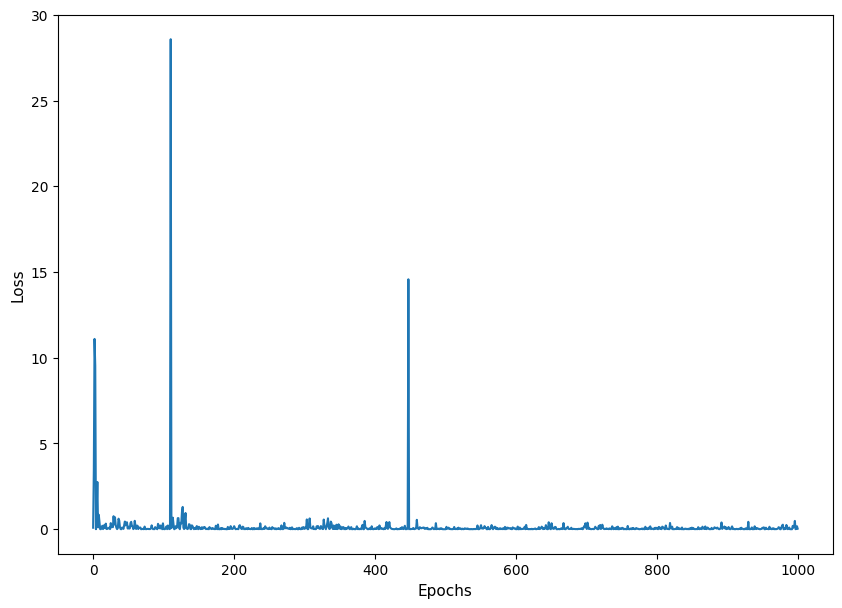

In [8]:
epochs = 1000
losses = [] #使用串列將每一次的loss記錄下來，方便之後將loss的變化趨勢畫成圖
for i in range(epochs):
  game = Gridworld(size=4, mode='player')
  state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0 #將3階的狀態陣列（4x4x4）轉換成向量（長度為64），並將每個值都加上一些雜訊（很小的數值）。
  state1 = torch.from_numpy(state_).float() #將NumPy陣列轉換成PyTorch張量，並存於state1中
  status = 1 #用來追蹤遊戲是否仍在繼續（『1』代表仍在繼續）
  while(status == 1):
    qval = model(state1) #執行Q網路，取得所有動作的預測Q值
    qval_ = qval.data.numpy() #將qval轉換成NumPy陣列
    if (random.random() < epsilon):
      action_ = np.random.randint(0,4) #隨機選擇一個動作（探索）
    else:
      action_ = np.argmax(qval_) #選擇Q值最大的動作（探索）
    action = action_set[action_] #將代表某動作的數字對應到makeMove()的英文字母
    game.makeMove(action) #執行之前ε—貪婪策略所選出的動作
    state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state2 = torch.from_numpy(state2_).float() #動作執行完畢，取得遊戲的新狀態並轉換成張量
    reward = game.reward()
    with torch.no_grad():
      newQ = model(state2.reshape(1,64))
    maxQ = torch.max(newQ) #將新狀態下所輸出的Q值向量中的最大值給記錄下來
    if reward == -1:
      Y = reward + (gamma * maxQ)  #計算訓練所用的目標Q值
    else: #若reward不等於-1，代表遊戲已經結束，也就沒有下一個狀態了，因此目標Q值就等於回饋值
      Y = reward
    Y = torch.Tensor([Y]).detach()
    X = qval.squeeze()[action_] #將演算法對執行的動作所預測的Q值存進X，並使用squeeze()將qval中維度為1的階去掉 (shape[1,4]會變成[4])
    loss = loss_fn(X, Y) #計算目標Q值與預測Q值之間的誤差
    if i%100 == 0:
      print(i, loss.item())
      clear_output(wait=True)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    state1 = state2
    if abs(reward) == 10:
      status = 0 # 若 reward 的絕對值為10，代表遊戲已經分出勝負，所以設status為0
  losses.append(loss.item())
  if epsilon > 0.1:
    epsilon -= (1/epochs) #讓ε的值隨著訓練的進行而慢慢下降，直到0.1（還是要保留探索的動作）
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=11)
plt.ylabel("Loss",fontsize=11)

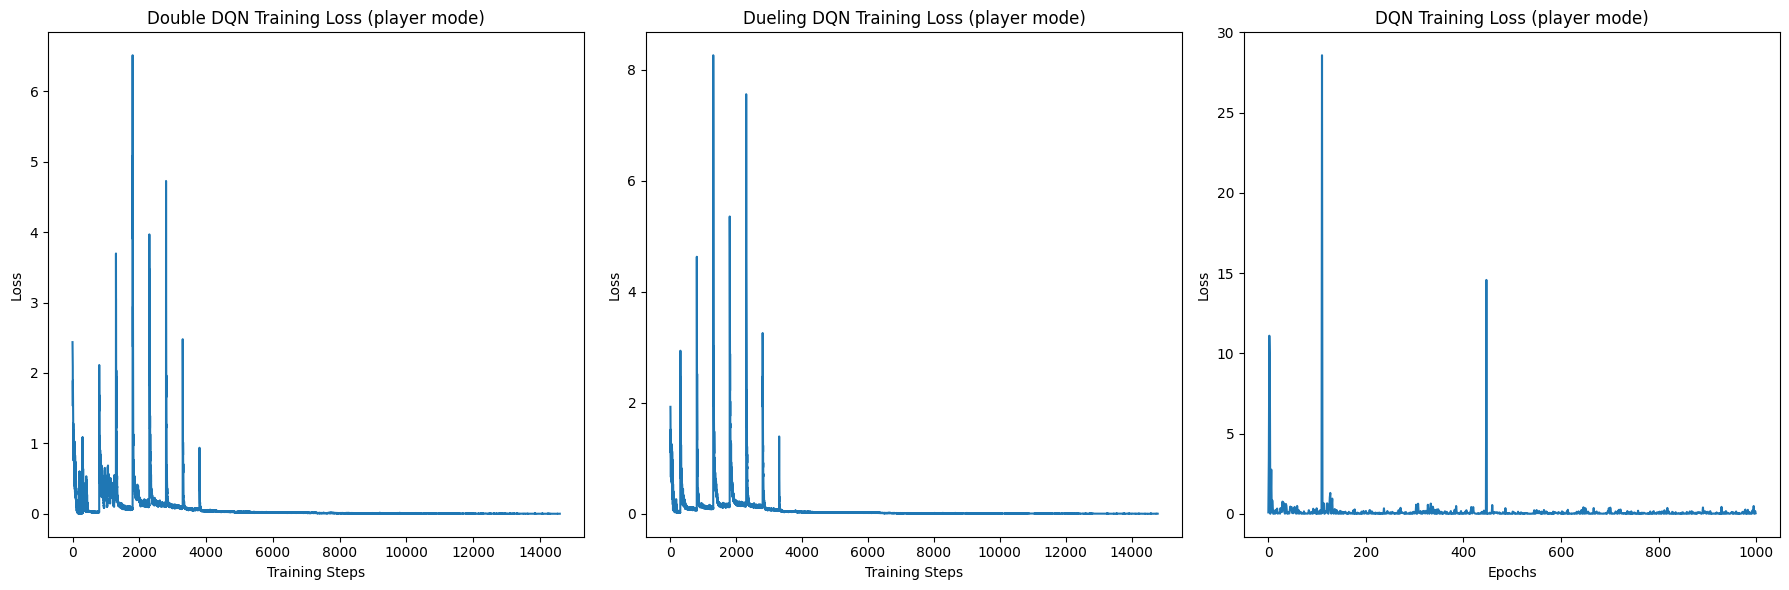

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))

# 第一個圖表：Double DQN Training Loss
plt.subplot(1, 3, 1)
plt.plot(DoubleDQN_losses)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Double DQN Training Loss (player mode)")

# 第二個圖表：Dueling DQN Training Loss
plt.subplot(1, 3, 2)
plt.plot(DuelingDQN_losses)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Dueling DQN Training Loss (player mode)")

# 第三個圖表：Basic DQN Training Loss
plt.subplot(1, 3, 3)
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("DQN Training Loss (player mode)")

# 顯示三個圖表
plt.tight_layout()
plt.show()


Double DQN 和 Dueling DQN 改進 Basic DQN 的方式
1. Double DQN 的改善
Double DQN 主要的改進是減少了 Q 值的過度估計問題。在基本 DQN 中，最大 Q 值是由同一個網路選擇動作並估算 Q 值，這可能會導致過高的期望回報，尤其是在動作空間很大或狀態空間很複雜時。

Double DQN 的解決方案：
Double DQN 透過引入兩個網路來解決過度估計問題：

主網路（model）用來選擇動作。

目標網路（model2）用來估算 Q 值。

在每一步更新時，主網路選擇動作，而目標網路則估算該動作的 Q 值，這樣可以減少 Q 值過度估計的問題。

公式：

在 基本 DQN 中，目標 Q 值的計算是：

𝑌
=
reward
+
𝛾
×
max
⁡
𝑎
′
𝑄
(
𝑠
′
,
𝑎
′
)
Y=reward+γ×
a
′

max
​
 Q(s
′
 ,a
′
 )
而在 Double DQN 中，目標 Q 值的計算方式是：

𝑌
=
reward
+
𝛾
×
𝑄
target
(
𝑠
′
,
arg
⁡
max
⁡
𝑎
′
𝑄
main
(
𝑠
′
,
𝑎
′
)
)
Y=reward+γ×Q
target
​
 (s
′
 ,arg
a
′

max
​
 Q
main
​
 (s
′
 ,a
′
 ))
這樣能夠減少 Q 值過度估計，並提供更穩定的學習過程。

觀察：
Double DQN 的損失曲線（第一張圖）顯示了相對平穩的學習過程。儘管存在波動，這比 Basic DQN 和 Dueling DQN 更為穩定，表明 Double DQN 能夠避免 Q 值過度估計的問題，並穩定學習。

2. Dueling DQN 的改善
Dueling DQN 提出將 Q 值分為兩個部分：

狀態價值（V(s)）：表示在某狀態下，代理人能夠期望的回報。

動作優勢（A(s, a)）：表示某一動作相對於其他動作的優勢。

這樣做的目的是讓模型能夠更精確地學習每個狀態的價值，並使動作選擇更具彈性。

Dueling DQN 的解決方案：
Dueling DQN 的公式為：

𝑄
(
𝑠
,
𝑎
)
=
𝑉
(
𝑠
)
+
(
𝐴
(
𝑠
,
𝑎
)
−
mean
(
𝐴
(
𝑠
,
𝑎
)
)
)
Q(s,a)=V(s)+(A(s,a)−mean(A(s,a)))
這樣，狀態價值和動作優勢分開處理，使得模型在學習過程中能夠捕捉更多的狀態特徵，並有效處理動作優勢差異。

觀察：
Dueling DQN 的損失曲線（第二張圖）顯示了較為穩定的學習過程。相較於 Basic DQN，Dueling DQN 能更有效地捕捉狀態的價值與動作的優勢，學習過程中的波動較小。




| 方法              | 優勢                        | 改進                                 |
| --------------- | ------------------------- | ---------------------------------- |
| **Basic DQN**   | 簡單，適用於簡單環境。               | 容易受到 Q 值過度估計影響，學習過程不穩定。            |
| **Double DQN**  | 減少了 Q 值過度估計的問題，使學習過程更穩定。  | 使用兩個網路（主網路和目標網路），減少了過度估計，提供了穩定的學習。 |
| **Dueling DQN** | 更有效地捕捉狀態價值與動作優勢，使模型學習更高效。 | 分離狀態價值和動作優勢，提高了學習效率，尤其在複雜環境中表現更好。  |


# 4-3


In [17]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import numpy as np
from Gridworld import Gridworld
from torch.optim.lr_scheduler import StepLR  # 引入學習率調度器

# 定義 DQN 模型（PyTorch Lightning 版）
class DQNLightning(pl.LightningModule):
    def __init__(self, input_dim, hidden1, hidden2, output_dim, gamma=0.9, epsilon=1.0):
        super(DQNLightning, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, output_dim)
        )

        self.target_model = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, output_dim)
        )

        self.gamma = gamma
        self.epsilon = epsilon
        self.loss_fn = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)
        self.replay_buffer = deque(maxlen=1000)
        self.batch_size = 64
        self.sync_freq = 500  # Target model sync frequency
        self.total_steps = 0

    def forward(self, x):
        return self.model(x)

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def compute_loss(self, state_batch, action_batch, reward_batch, next_state_batch, done_batch):
        current_q_values = self.model(state_batch).gather(1, action_batch.unsqueeze(1))

        with torch.no_grad():
            next_actions = torch.argmax(self.model(next_state_batch), dim=1)
            target_q_values = self.target_model(next_state_batch).gather(1, next_actions.unsqueeze(1))

        target = reward_batch + self.gamma * (1 - done_batch) * target_q_values
        loss = self.loss_fn(current_q_values.squeeze(), target.squeeze())
        return loss

    def training_step(self, batch, batch_idx):
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = batch

        loss = self.compute_loss(state_batch, action_batch, reward_batch, next_state_batch, done_batch)

        # 梯度裁剪：確保梯度不會太大，避免梯度爆炸
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)

        return loss

    def configure_optimizers(self):
        # 添加學習率調度器
        scheduler = StepLR(self.optimizer, step_size=100, gamma=0.7)  # 每100步調整學習率
        return [self.optimizer], [scheduler]

    def train_dqn(self, epochs=1000, game_mode="random"):
        # 初始化 DQN 訓練
        for epoch in range(epochs):
            game = Gridworld(size=4, mode=game_mode)
            state_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
            state1 = torch.from_numpy(state_).float()
            status = 1
            while status == 1:
                self.total_steps += 1

                # 使用 epsilon-greedy 進行探索
                if random.random() < self.epsilon:
                    action_ = np.random.randint(0, 4)
                else:
                    qval = self.model(state1)
                    action_ = torch.argmax(qval).item()

                action = action_set[action_]
                game.makeMove(action)

                state2_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
                state2 = torch.from_numpy(state2_).float()
                reward = game.reward()
                done = reward != -1

                self.replay_buffer.append((state1, action_, reward, state2, done))
                state1 = state2

                if len(self.replay_buffer) > self.batch_size:
                    minibatch = random.sample(self.replay_buffer, self.batch_size)
                    state_batch = torch.cat([s1 for (s1, a, r, s2, d) in minibatch])
                    action_batch = torch.tensor([a for (s1, a, r, s2, d) in minibatch])
                    reward_batch = torch.tensor([r for (s1, a, r, s2, d) in minibatch])
                    state2_batch = torch.cat([s2 for (s1, a, r, s2, d) in minibatch])
                    done_batch = torch.tensor([d for (s1, a, r, s2, d) in minibatch])

                    # 訓練步驟
                    self.optimizer.zero_grad()
                    loss = self.compute_loss(state_batch, action_batch, reward_batch, state2_batch, done_batch)
                    loss.backward()
                    self.optimizer.step()

                    # 每訓練一定步數同步目標網路
                    if self.total_steps % self.sync_freq == 0:
                        self.update_target_model()

                if abs(reward) == 10:
                    status = 0
            # 梯度裁剪和學習率調度
            if self.epsilon > 0.1:
                self.epsilon -= 1 / epochs


In [20]:
from torch.utils.data import DataLoader, TensorDataset

class DQNLightning(pl.LightningModule):
    def __init__(self, input_dim, hidden1, hidden2, output_dim, gamma=0.9, epsilon=1.0):
        super(DQNLightning, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, output_dim)
        )

        self.target_model = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, output_dim)
        )

        self.gamma = gamma
        self.epsilon = epsilon
        self.loss_fn = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)
        self.replay_buffer = deque(maxlen=1000)
        self.batch_size = 64
        self.sync_freq = 500  # Target model sync frequency
        self.total_steps = 0

        # 損失記錄
        self.losses = []

    def forward(self, x):
        return self.model(x)

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def compute_loss(self, state_batch, action_batch, reward_batch, next_state_batch, done_batch):
        current_q_values = self.model(state_batch).gather(1, action_batch.unsqueeze(1))

        with torch.no_grad():
            next_actions = torch.argmax(self.model(next_state_batch), dim=1)
            target_q_values = self.target_model(next_state_batch).gather(1, next_actions.unsqueeze(1))

        target = reward_batch + self.gamma * (1 - done_batch) * target_q_values
        loss = self.loss_fn(current_q_values.squeeze(), target.squeeze())
        return loss

    def training_step(self, batch, batch_idx):
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = batch

        loss = self.compute_loss(state_batch, action_batch, reward_batch, next_state_batch, done_batch)

        # 記錄每次訓練的損失
        self.losses.append(loss.item())

        # 梯度裁剪
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)

        return loss

    def configure_optimizers(self):
        scheduler = StepLR(self.optimizer, step_size=100, gamma=0.7)
        return [self.optimizer], [scheduler]

    def train_dataloader(self):
        # 創建一個簡單的訓練資料集：你需要根據你的情況定制資料
        # 這裡假設你已經有訓練資料。為了示範，這裡生成隨機資料。

        # 假設你有訓練狀態(state)、動作(action)、回報(reward)、下一狀態(next_state) 和結束標記(done)
        state_data = np.random.rand(1000, 64)  # 隨機生成狀態資料
        action_data = np.random.randint(0, 4, 1000)  # 隨機生成動作（0, 1, 2, 3）
        reward_data = np.random.rand(1000)  # 隨機生成回報
        next_state_data = np.random.rand(1000, 64)  # 隨機生成下一狀態
        done_data = np.random.randint(0, 2, 1000)  # 隨機生成結束標記（0 或 1）

        # 將資料轉換為 PyTorch tensor
        dataset = TensorDataset(
            torch.Tensor(state_data),
            torch.Tensor(action_data).long(),
            torch.Tensor(reward_data),
            torch.Tensor(next_state_data),
            torch.Tensor(done_data)
        )

        # 返回 DataLoader
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=True)


INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type       | Params | Mode 
----------------------------------------------------
0 | model        | Sequential | 25.3 K | train
1 | target_model | Sequential | 25.3 K | train
2 | loss_fn      | MSELoss    | 0      | train
----------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([40, 40])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1000` reached.


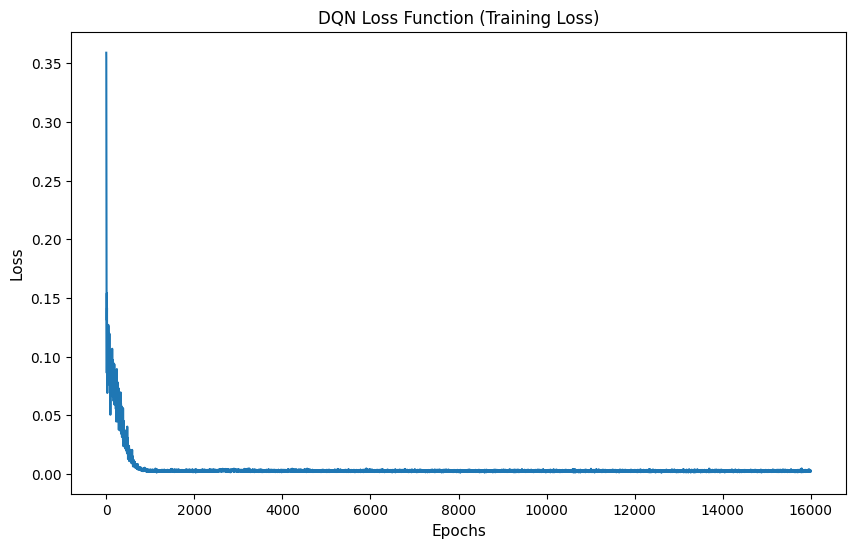

In [21]:
# 創建 Lightning 模型並進行訓練
dqn_model = DQNLightning(input_dim=64, hidden1=150, hidden2=100, output_dim=4)
trainer = pl.Trainer(max_epochs=1000, logger=logger)
trainer.fit(dqn_model)

# 訓練結束後畫出損失曲線
plt.figure(figsize=(10, 6))
plt.plot(dqn_model.losses)
plt.xlabel("Epochs", fontsize=11)
plt.ylabel("Loss", fontsize=11)
plt.title("DQN Loss Function (Training Loss)")
plt.show()


# 原始檔

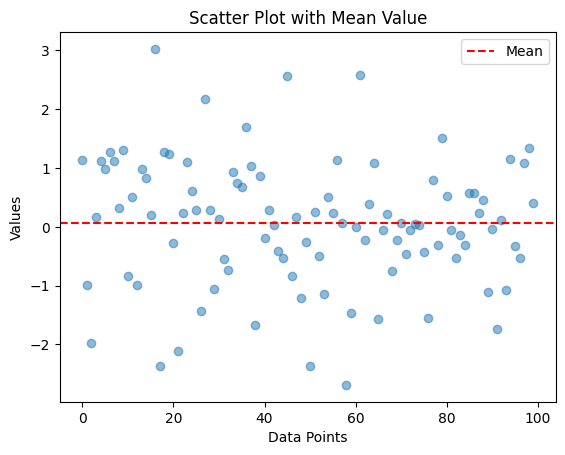

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data
data = np.random.randn(100)

# Calculate the mean value
mean_value = np.mean(data)

# Plot the data with alpha level
plt.scatter(range(len(data)), data, alpha=0.5)

# Add a horizontal line for the mean value
plt.axhline(mean_value, color='red', linestyle='--', label='Mean')

# Set plot properties
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.title('Scatter Plot with Mean Value')
plt.legend()

# Display the plot
plt.show()

# 程式 3.1: 建立一個Gridworld遊戲

In [2]:
# 下載 Gridworld.py 及 GridBoard.py (-q 是設為安靜模式)
!wget -q https://github.com/DeepReinforcementLearning/DeepReinforcementLearningInAction/raw/master/Errata/Gridworld.py
!wget -q https://github.com/DeepReinforcementLearning/DeepReinforcementLearningInAction/raw/master/Errata/GridBoard.py

from Gridworld import Gridworld
game = Gridworld(size=4, mode='static')

In [ ]:
game.display()

array([['+', '-', ' ', 'P'],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [ ]:
game.makeMove('d')

In [ ]:
game.display()

array([['+', '-', ' ', ' '],
       [' ', 'W', ' ', 'P'],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [ ]:
game.reward()

-1

In [ ]:
game.board.render_np()

array([[[0, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

In [ ]:
game.board.render_np().shape

(4, 4, 4)

# 程式 3.2

In [ ]:
import numpy as np
import torch
from Gridworld import Gridworld
from IPython.display import clear_output
import random
from matplotlib import pylab as plt

L1 = 64 #輸入層的寬度
L2 = 150 #第一隱藏層的寬度
L3 = 100 #第二隱藏層的寬度
L4 = 4 #輸出層的寬度

model = torch.nn.Sequential(
    torch.nn.Linear(L1, L2), #第一隱藏層的shape
    torch.nn.ReLU(),
    torch.nn.Linear(L2, L3), #第二隱藏層的shape
    torch.nn.ReLU(),
    torch.nn.Linear(L3,L4) #輸出層的shape
)
loss_fn = torch.nn.MSELoss() #指定損失函數為MSE（均方誤差）
learning_rate = 1e-3  #設定學習率
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #指定優化器為Adam，其中model.parameters會傳回所有要優化的權重參數

gamma = 0.9 #折扣因子
epsilon = 1.0

##將動作的字母與數字對應起來

In [ ]:
action_set = {
	0: 'u', #『0』代表『向上』
	1: 'd', #『1』代表『向下』
	2: 'l', #『2』代表『向左』
	3: 'r' #『3』代表『向右』
}

# 程式 3.3: 主要訓練迴圈

Text(0, 0.5, 'Loss')

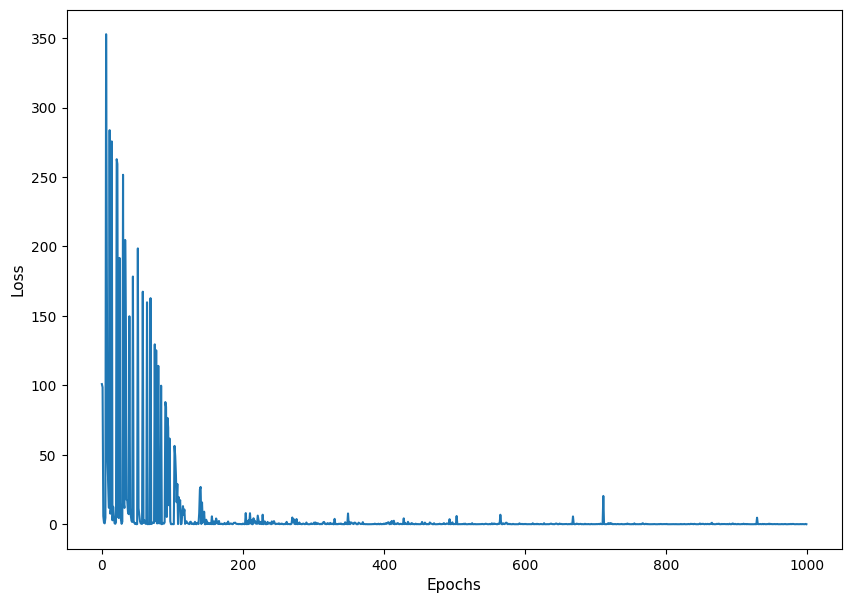

In [ ]:
epochs = 1000
losses = [] #使用串列將每一次的loss記錄下來，方便之後將loss的變化趨勢畫成圖
for i in range(epochs):
# 註解1:
  game = Gridworld(size=4, mode='static')
  state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0 #將3階的狀態陣列（4x4x4）轉換成向量（長度為64），並將每個值都加上一些雜訊（很小的數值）。
  state1 = torch.from_numpy(state_).float() #將NumPy陣列轉換成PyTorch張量，並存於state1中
  status = 1 #用來追蹤遊戲是否仍在繼續（『1』代表仍在繼續）
  while(status == 1):
    qval = model(state1) #執行Q網路，取得所有動作的預測Q值
    qval_ = qval.data.numpy() #將qval轉換成NumPy陣列
    if (random.random() < epsilon):
      action_ = np.random.randint(0,4) #隨機選擇一個動作（探索）
    else:
      action_ = np.argmax(qval_) #選擇Q值最大的動作（探索）
    action = action_set[action_] #將代表某動作的數字對應到makeMove()的英文字母
    game.makeMove(action) #執行之前ε—貪婪策略所選出的動作
    state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state2 = torch.from_numpy(state2_).float() #動作執行完畢，取得遊戲的新狀態並轉換成張量
    reward = game.reward()
    with torch.no_grad():
      newQ = model(state2.reshape(1,64))
    maxQ = torch.max(newQ) #將新狀態下所輸出的Q值向量中的最大值給記錄下來
    if reward == -1:
      Y = reward + (gamma * maxQ)  #計算訓練所用的目標Q值
    else: #若reward不等於-1，代表遊戲已經結束，也就沒有下一個狀態了，因此目標Q值就等於回饋值
      Y = reward
    Y = torch.Tensor([Y]).detach()
    X = qval.squeeze()[action_] #將演算法對執行的動作所預測的Q值存進X，並使用squeeze()將qval中維度為1的階去掉 (shape[1,4]會變成[4])
    loss = loss_fn(X, Y) #計算目標Q值與預測Q值之間的誤差
    if i%100 == 0:
      print(i, loss.item())
      clear_output(wait=True)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    state1 = state2
    if abs(reward) == 10:
      status = 0 # 若 reward 的絕對值為10，代表遊戲已經分出勝負，所以設status為0
  losses.append(loss.item())
  if epsilon > 0.1:
    epsilon -= (1/epochs) #讓ε的值隨著訓練的進行而慢慢下降，直到0.1（還是要保留探索的動作）
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=11)
plt.ylabel("Loss",fontsize=11)

##torch.no_grad的效果說明

In [ ]:
m = torch.Tensor([2.0])
m.requires_grad=True
b = torch.Tensor([1.0])
b.requires_grad=True
def linear_model(x,m,b):
  y = m*x + b
  return y
y = linear_model(torch.Tensor([4.]),m,b)
y

tensor([9.], grad_fn=<AddBackward0>)

In [ ]:
y.grad_fn

In [ ]:
with torch.no_grad():
  y = linear_model(torch.Tensor([4.]),m,b)
y

tensor([9.])

In [ ]:
y.grad_fn

In [ ]:
y = linear_model(torch.Tensor([4.]),m,b)
y.backward()
m.grad

tensor([4.])

In [ ]:
b.grad

tensor([1.])

# 程式 3.4： 測試Q網路

In [ ]:
def test_model(model, mode='static', display=True):
    i = 0
    test_game = Gridworld(size=4, mode=mode) #產生一場測試遊戲
    state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state = torch.from_numpy(state_).float()
    if display:
      print("Initial State:")
      print(test_game.display())
    status = 1
    while(status == 1): #遊戲仍在進行
      qval = model(state)
      qval_ = qval.data.numpy()
      action_ = np.argmax(qval_)
      action = action_set[action_]
      if display:
        print('Move #: %s; Taking action: %s' % (i, action))
      test_game.makeMove(action)
      state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
      state = torch.from_numpy(state_).float()
      if display:
        print(test_game.display())
      reward = test_game.reward()
      if reward != -1: #代表勝利（抵達終點）或落敗（掉入陷阱）
        if reward > 0: #reward>0，代表成功抵達終點
          status = 2 #將狀態設為2，跳出迴圈
          if display:
            print("Game won! Reward: %s" %reward)
          else: #掉入陷阱
            status = 0 #將狀態設為0，跳出迴圈
            if display:
              print("Game LOST. Reward: %s" %reward)
      i += 1 #每移動一步，i就加1
      if (i > 15): #若移動了15步，仍未取出勝利，則一樣視為落敗
        if display:
          print("Game lost; too many moves.")
        break
    win = True if status == 2 else False
    print(win)
    return win

## 測試模型（static mode)

In [ ]:
test_model(model, 'static')

Initial State:
[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' 'P']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' 'P' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 4; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 5; Taking action: u
[['+' '-' ' ' ' ']
 ['P' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 6; Taking action: u
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10
True


True

## 測試模型 (random mode）

In [ ]:
test_model(model, 'random') #將游戲的生成模式改成random，再次測試模型

Initial State:
[[' ' ' ' ' ' ' ']
 [' ' ' ' 'P' ' ']
 ['-' ' ' ' ' ' ']
 ['W' ' ' '+' ' ']]
Move #: 0; Taking action: d
[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['-' ' ' 'P' ' ']
 ['W' ' ' '+' ' ']]
Move #: 1; Taking action: l
[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['-' 'P' ' ' ' ']
 ['W' ' ' '+' ' ']]
Move #: 2; Taking action: l
[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['-' ' ' ' ' ' ']
 ['W' ' ' '+' ' ']]
Move #: 3; Taking action: u
[[' ' ' ' ' ' ' ']
 ['P' ' ' ' ' ' ']
 ['-' ' ' ' ' ' ']
 ['W' ' ' '+' ' ']]
Move #: 4; Taking action: u
[['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['-' ' ' ' ' ' ']
 ['W' ' ' '+' ' ']]
Move #: 5; Taking action: d
[[' ' ' ' ' ' ' ']
 ['P' ' ' ' ' ' ']
 ['-' ' ' ' ' ' ']
 ['W' ' ' '+' ' ']]
Move #: 6; Taking action: u
[['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['-' ' ' ' ' ' ']
 ['W' ' ' '+' ' ']]
Move #: 7; Taking action: d
[[' ' ' ' ' ' ' ']
 ['P' ' ' ' ' ' ']
 ['-' ' ' ' ' ' ']
 ['W' ' ' '+' ' ']]
Move #: 8; Taking action: u
[['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [

False

## 將程式3.3的遊戲生成模式改成random，並進行1000次訓練

Text(0, 0.5, 'Loss')

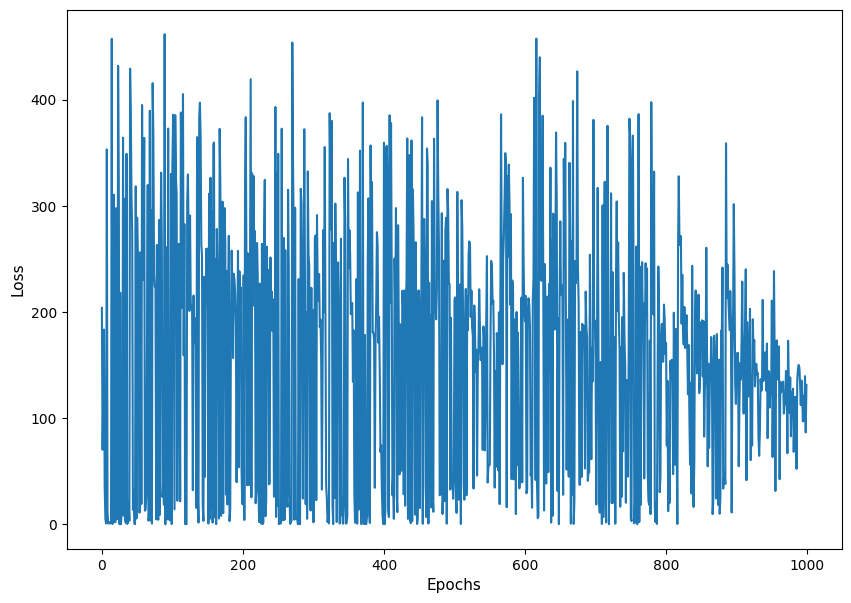

In [ ]:
epochs = 1000
losses = [] #使用串列將每一次的loss記錄下來，方便之後將loss的變化趨勢畫成圖
for i in range(epochs):
  game = Gridworld(size=4, mode='random')
  state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0 #將3階的狀態陣列（4x4x4）轉換成向量（長度為64），並將每個值都加上一些雜訊（很小的數值）。
  state1 = torch.from_numpy(state_).float() #將NumPy陣列轉換成PyTorch張量，並存於state1中
  status = 1 #用來追蹤遊戲是否仍在繼續（『1』代表仍在繼續）
  while(status == 1):
    qval = model(state1) #執行Q網路，取得所有動作的預測Q值
    qval_ = qval.data.numpy() #將qval轉換成NumPy陣列
    if (random.random() < epsilon):
      action_ = np.random.randint(0,4) #隨機選擇一個動作（探索）
    else:
      action_ = np.argmax(qval_) #選擇Q值最大的動作（探索）
    action = action_set[action_] #將代表某動作的數字對應到makeMove()的英文字母
    game.makeMove(action) #執行之前ε—貪婪策略所選出的動作
    state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state2 = torch.from_numpy(state2_).float() #動作執行完畢，取得遊戲的新狀態並轉換成張量
    reward = game.reward()
    with torch.no_grad():
      newQ = model(state2.reshape(1,64))
    maxQ = torch.max(newQ) #將新狀態下所輸出的Q值向量中的最大值給記錄下來
    if reward == -1:
      Y = reward + (gamma * maxQ)  #計算訓練所用的目標Q值
    else: #若reward不等於-1，代表遊戲已經結束，也就沒有下一個狀態了，因此目標Q值就等於回饋值
      Y = reward
    Y = torch.Tensor([Y]).detach()
    X = qval.squeeze()[action_] #將演算法對執行的動作所預測的Q值存進X，並使用squeeze()將qval中維度為1的階去掉 (shape[1,4]會變成[4])
    loss = loss_fn(X, Y) #計算目標Q值與預測Q值之間的誤差
    if i%100 == 0:
      print(i, loss.item())
      clear_output(wait=True)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    state1 = state2
    if abs(reward) == 10:
      status = 0 # 若 reward 的絕對值為10，代表遊戲已經分出勝負，所以設status為0
  losses.append(loss.item())
  if epsilon > 0.1:
    epsilon -= (1/epochs) #讓ε的值隨著訓練的進行而慢慢下降，直到0.1（還是要保留探索的動作）
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=11)
plt.ylabel("Loss",fontsize=11)

## 將程式3.3的遊戲生成模式改成player，並進行1000次訓練

Text(0, 0.5, 'Loss')

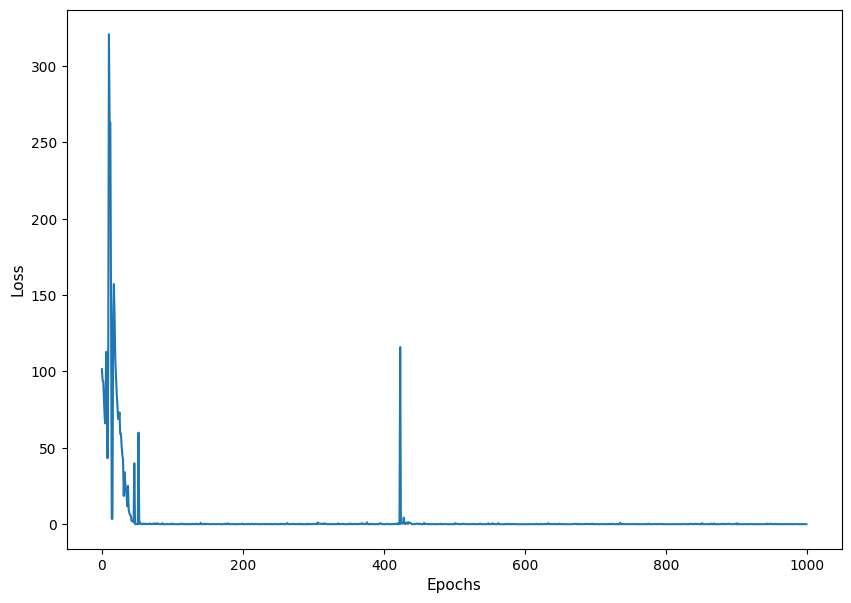

In [ ]:
epochs = 1000
losses = [] #使用串列將每一次的loss記錄下來，方便之後將loss的變化趨勢畫成圖
for i in range(epochs):
  game = Gridworld(size=4, mode='player')
  state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0 #將3階的狀態陣列（4x4x4）轉換成向量（長度為64），並將每個值都加上一些雜訊（很小的數值）。
  state1 = torch.from_numpy(state_).float() #將NumPy陣列轉換成PyTorch張量，並存於state1中
  status = 1 #用來追蹤遊戲是否仍在繼續（『1』代表仍在繼續）
  while(status == 1):
    qval = model(state1) #執行Q網路，取得所有動作的預測Q值
    qval_ = qval.data.numpy() #將qval轉換成NumPy陣列
    if (random.random() < epsilon):
      action_ = np.random.randint(0,4) #隨機選擇一個動作（探索）
    else:
      action_ = np.argmax(qval_) #選擇Q值最大的動作（探索）
    action = action_set[action_] #將代表某動作的數字對應到makeMove()的英文字母
    game.makeMove(action) #執行之前ε—貪婪策略所選出的動作
    state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state2 = torch.from_numpy(state2_).float() #動作執行完畢，取得遊戲的新狀態並轉換成張量
    reward = game.reward()
    with torch.no_grad():
      newQ = model(state2.reshape(1,64))
    maxQ = torch.max(newQ) #將新狀態下所輸出的Q值向量中的最大值給記錄下來
    if reward == -1:
      Y = reward + (gamma * maxQ)  #計算訓練所用的目標Q值
    else: #若reward不等於-1，代表遊戲已經結束，也就沒有下一個狀態了，因此目標Q值就等於回饋值
      Y = reward
    Y = torch.Tensor([Y]).detach()
    X = qval.squeeze()[action_] #將演算法對執行的動作所預測的Q值存進X，並使用squeeze()將qval中維度為1的階去掉 (shape[1,4]會變成[4])
    loss = loss_fn(X, Y) #計算目標Q值與預測Q值之間的誤差
    if i%100 == 0:
      print(i, loss.item())
      clear_output(wait=True)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    state1 = state2
    if abs(reward) == 10:
      status = 0 # 若 reward 的絕對值為10，代表遊戲已經分出勝負，所以設status為0
  losses.append(loss.item())
  if epsilon > 0.1:
    epsilon -= (1/epochs) #讓ε的值隨著訓練的進行而慢慢下降，直到0.1（還是要保留探索的動作）
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=11)
plt.ylabel("Loss",fontsize=11)

## 重建模型（同程式3.2）

In [ ]:
import numpy as np
import torch
from Gridworld import Gridworld
from IPython.display import clear_output
import random
from matplotlib import pylab as plt

L1 = 64 #輸入層的寬度
L2 = 150 #第一隱藏層的寬度
L3 = 100 #第二隱藏層的寬度
L4 = 4 #輸出層的寬度

model = torch.nn.Sequential(
    torch.nn.Linear(L1, L2), #第一隱藏層的shape
    torch.nn.ReLU(),
    torch.nn.Linear(L2, L3), #第二隱藏層的shape
    torch.nn.ReLU(),
    torch.nn.Linear(L3,L4) #輸出層的shape
)
loss_fn = torch.nn.MSELoss() #指定損失函數為MSE（均方誤差）
learning_rate = 1e-3  #設定學習率
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #指定優化器為Adam，其中model.parameters會傳回所有要優化的權重參數

gamma = 0.9 #折扣因子
epsilon = 1.0

# 程式 3.5: 包含經驗回放的DQN

In [ ]:
from collections import deque
epochs = 5000 #訓練5000次
losses = []
mem_size = 1000 #設定記憶串列的大小
batch_size = 200 #設定單一小批次（mini_batch）的大小
replay = deque(maxlen=mem_size) #產生一個記憶串列（資料型別為deque）來儲存經驗回放的資料，並將其命名為replay
max_moves = 50 #設定每場遊戲最多可以走幾步
for i in range(epochs):
  game = Gridworld(size=4, mode='random')
  state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
  state1 = torch.from_numpy(state1_).float()
  status = 1
  mov = 0 #記錄移動的步數，初始化為0
  while(status == 1):
    mov += 1
    qval = model(state1) #輸出各動作的Q值
    qval_ = qval.data.numpy()
    if (random.random() < epsilon):
      action_ = np.random.randint(0,4)
    else:
      action_ = np.argmax(qval_)
    action = action_set[action_]
    game.makeMove(action)
    state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state2 = torch.from_numpy(state2_).float()
    reward = game.reward()
    done = True if reward != -1 else False #在reward不等於-1時設定done=True，代表遊戲已經結束了（分出勝負時，reward會等於10或-10）
    exp = (state1, action_, reward, state2, done) #產生一筆經驗，其中包含當前狀態、動作、新狀態、回饋值及done值
    replay.append(exp) #將該經驗加入名為replay的deque串列中
    state1 = state2 #產生的新狀態會變成下一次訓練時的輸入狀態
    if len(replay) > batch_size: #當replay的長度大於小批次量（mini-batch size）時，啟動小批次訓練
      minibatch = random.sample(replay, batch_size) #隨機選擇replay中的資料來組成子集
      state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch]) #將經驗中的不同元素分別儲存到對應的小批次張量中
      action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
      reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
      state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
      done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
      Q1 = model(state1_batch) #利用小批次資料中的『目前狀態批次』來計算Q值3
      with torch.no_grad():
        Q2 = model(state2_batch) #利用小批次資料中的新狀態來計算Q值，但設定為不需要計算梯度
      Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2,dim=1)[0]) #計算我們希望DQN學習的目標Q值
      X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
      loss = loss_fn(X, Y.detach())
      print(i, loss.item())
      clear_output(wait=True)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    if abs(reward) == 10 or mov > max_moves:
      status = 0
      mov = 0 #若遊戲結束，則重設status和mov變數的值
    losses.append(loss.item())
  if epsilon > 0.1:
    epsilon -= (1/epochs) #讓ε的值隨著訓練的進行而慢慢下降，直到0.1（還是要保留探索的動作）
losses = np.array(losses)
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Steps",fontsize=11)
plt.ylabel("Loss",fontsize=11)

KeyboardInterrupt: ignored

## 小編補充：gather()和unsqueeze()的函式說明

In [ ]:
t = torch.Tensor([ [1, 2, 3],
          [4, 5, 6],
          [7, 8, 9]])
indices = torch.Tensor([ [2],
            [0],
            [1]])
torch.gather(input=t,dim=1,index=indices.long())

In [ ]:
x = torch.tensor([1,2,3,4])
y = torch.unsqueeze(input=x, dim=0) #在x張量的第0階加入一個1維的階
print(y.shape)

# 程式 3.6：測試具備經驗回放機制的模型

In [ ]:
max_games = 1000 #模擬1000次遊戲
wins = 0
for i in range(max_games):
  win = test_model(model, mode='random') #利用random模式來進行測試
  if win:
    wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc)) #顯示勝率

# 程式 3.7： 目標網路 (解決 Overestimate Q 的問題)

In [ ]:
import copy

L1 = 64
L2 = 150
L3 = 100
L4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(L1, L2),
    torch.nn.ReLU(),
    torch.nn.Linear(L2, L3),
    torch.nn.ReLU(),
    torch.nn.Linear(L3,L4)
)

model2 = copy.deepcopy(model) #完整複製原始Q網路模型，產生目標網路模型
model2.load_state_dict(model.state_dict()) #將原始Q網路中的參數複製給目標網路
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 1.0


# 程式 3.8： 利用經驗回放和目標網路訓練DQN

In [ ]:
from collections import deque
epochs = 5000
losses = []
mem_size = 1000 #設定記憶串列的大小
batch_size = 200 #設定批次大小
replay = deque(maxlen=mem_size)
max_moves = 50
sync_freq = 500 #設定Q網路和目標網路的參數同步頻率（每500步就同步一次參數）
j=0 #記錄當前訓練次數
for i in range(epochs):
  game = Gridworld(size=4, mode='random')
  state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
  state1 = torch.from_numpy(state1_).float()
  status = 1
  mov = 0
  while(status == 1):
    j+=1 #將訓練次數加1
    mov += 1
    qval = model(state1)
    qval_ = qval.data.numpy()
    if (random.random() < epsilon):
      action_ = np.random.randint(0,4)
    else:
      action_ = np.argmax(qval_)
    action = action_set[action_]
    game.makeMove(action)
    state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state2 = torch.from_numpy(state2_).float()
    reward = game.reward()
    done = True if reward != -1 else False
    exp =  (state1, action_, reward, state2, done)
    replay.append(exp)
    state1 = state2
    if len(replay) > batch_size:
      minibatch = random.sample(replay, batch_size)
      state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch])
      action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
      reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
      state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
      done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
      Q1 = model(state1_batch)
      with torch.no_grad():     #用目標網路模型計算Q值, 但不要優化模型的參數
        Q2 = model2(state2_batch)
      Y = reward_batch + gamma * ((1-done_batch) * torch.max(Q2,dim=1)[0])
      X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
      loss = loss_fn(X, Y.detach())
      print(i, loss.item())
      clear_output(wait=True)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if j % sync_freq == 0: #每500步，就將Q網路當前的參數複製一份給目標網路
        model2.load_state_dict(model.state_dict())
    if reward != -1 or mov > max_moves:
      status = 0
      mov = 0
    losses.append(loss.item())
  if epsilon > 0.1:
    epsilon -= (1/epochs) #讓ε的值隨著訓練的進行而慢慢下降，直到0.1（還是要保留探索的動作）
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Steps",fontsize=11)
plt.ylabel("Loss",fontsize=11)

## 測試勝率

In [ ]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='random')
    if win:
      wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc)) #顯示勝率

# 程式 3.5 改良版 （加入『學習避免撞牆』機制）

In [ ]:
model = torch.nn.Sequential(
    torch.nn.Linear(L1, L2), #第一隱藏層
    torch.nn.ReLU(),
    torch.nn.Linear(L2, L3), #第二隱藏層
    torch.nn.ReLU(),
    torch.nn.Linear(L3,L4) #輸出層
)
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3  #超參數『α』
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #model.parameters()會傳回所有要優化的權重參數

gamma = 0.9
epsilon = 1.0

#————————————————

from collections import deque
epochs = 5000
losses = []
mem_size = 1000 #設定記憶串列的大小
batch_size = 200 #設定單一小批次（mini_batch）的大小
move_pos = [(-1,0),(1,0),(0,-1),(0,1)]   #●移動方向 u,d,l,r 的實際移動向量
replay = deque(maxlen=mem_size) #產生一個deque串列來儲存經驗回放的資料
max_moves = 50 #設定每場遊戲最多可以走幾步
for i in range(epochs):
  game = Gridworld(size=4, mode='random')
  state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
  state1 = torch.from_numpy(state1_).float()
  status = 1
  mov = 0 #移動的步數
  while(status == 1):
    mov += 1
    qval = model(state1) #輸出各動作的Q值
    qval_ = qval.data.numpy()
    if (random.random() < epsilon):
      action_ = np.random.randint(0,4)
    else:
      action_ = np.argmax(qval_)
    hit_wall = game.validateMove('Player', move_pos[action_]) == 1 #●若有撞牆的動作，hit_wall就為True
    action = action_set[action_]
    game.makeMove(action)
    state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state2 = torch.from_numpy(state2_).float()
    reward = -5 if hit_wall else game.reward() #●2.若撞牆回饋-5
    done = True if reward != -1 else False #在reward不等於-1時設定done=True，代表遊戲已經結束了（分出勝負時，reward會等於10或-10）
    exp = (state1, action_, reward, state2, done) #產生一筆經驗，其中包含當前狀態、動作、新狀態、回饋值及done值
    replay.append(exp) #將該經驗加入名為replay的deque串列中
    state1 = state2 #產生的新狀態會變成下一次訓練時的輸入狀態
    if len(replay) > batch_size: #當replay的長度大於小批次量（mini-batch size）時，啟動小批次訓練
      minibatch = random.sample(replay, batch_size) #隨機選擇replay中的資料來組成子集
      state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch]) #{5}將經驗中的不同元素分別儲存到對應的小批次張量中
      action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
      reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
      state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
      done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
      Q1 = model(state1_batch) #利用小批次資料中的目前狀態來計算Q值
      with torch.no_grad():
        Q2 = model(state2_batch) #利用小批次資料中的新狀態來計算Q值，但設定為不需要計算梯度
      Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2,dim=1)[0]) #計算我們希望DQN學習的目標Q值
      X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze() #gather()及unsqueeze()函式的用途可參見下面的小編補充框
      loss = loss_fn(X, Y.detach())
      if i%100 == 0:
        print(i, loss.item())
        clear_output(wait=True)
      optimizer.zero_grad()
      loss.backward()
      losses.append(loss.item())
      optimizer.step()
    if abs(reward) == 10 or mov > max_moves:
      status = 0
      mov = 0 #若遊戲結束，則重設status和mov變數的值
  if epsilon > 0.1:
    epsilon -= (1/epochs) #讓ε的值隨著訓練的進行而慢慢下降，直到0.1（還是要保留探索的動作）
losses = np.array(losses)
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Steps",fontsize=11)
plt.ylabel("Loss",fontsize=11)

#——————————————

max_games = 1000
wins = 0
for i in range(max_games):
  win = test_model(model, mode='random')
  if win:
    wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc)) #顯示勝率